# Chapter 4 - Classification

In [1]:
import warnings
warnings.filterwarnings('ignore')

- [Load dataset](#Load-dataset)
- [The Default data set](#Figure-4.1---Default-data-set)
- [4.3 Logistic Regression](#4.3-Logistic-Regression)
- [4.4 Linear Discriminant Analysis](#4.4-Linear-Discriminant-Analysis)
- [Lab: 4.6.3 Linear Discriminant Analysis](#4.6.3-Linear-Discriminant-Analysis)
- [Lab: 4.6.4 Quadratic Discriminant Analysis](#4.6.4-Quadratic-Discriminant-Analysis)
- [Lab: 4.6.5 K-Nearest Neighbors](#4.6.5-K-Nearest-Neighbors)
- [Lab: 4.6.6 An Application to Caravan Insurance Data](#4.6.6-An-Application-to-Caravan-Insurance-Data)

In [2]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
sns.set_theme()
sns.set_style("ticks")
# plt.style.use('seaborn-white')

### Load dataset

In [3]:
!wget https://github.com/tvanzyl/ISLR-python/raw/master/Notebooks/Data/Default.xlsx -N
# In R, I exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('Default.xlsx', index_col=0)

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

--2022-09-15 10:01:26--  https://github.com/tvanzyl/ISLR-python/raw/master/Notebooks/Data/Default.xlsx
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/tvanzyl/ISL1_Python/raw/master/Notebooks/Data/Default.xlsx [following]
--2022-09-15 10:01:28--  https://github.com/tvanzyl/ISL1_Python/raw/master/Notebooks/Data/Default.xlsx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tvanzyl/ISL1_Python/master/Notebooks/Data/Default.xlsx [following]
--2022-09-15 10:01:28--  https://raw.githubusercontent.com/tvanzyl/ISL1_Python/master/Notebooks/Data/Default.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

,default,student,balance,income,default2,student2
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


###  Figure 4.1 - Default data set

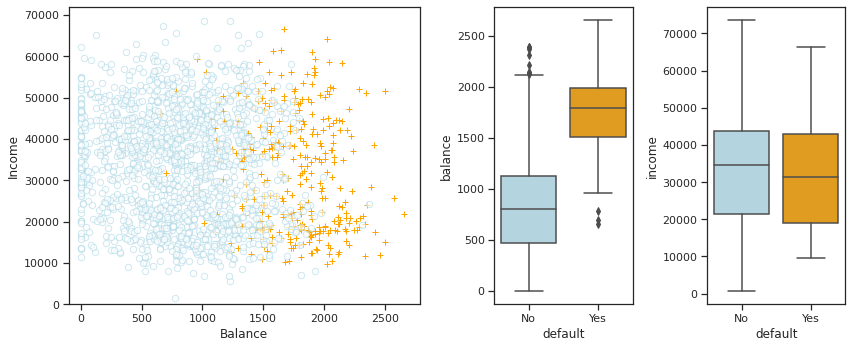

In [4]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths=1,
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot('default', 'balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

## 4.3 Logistic Regression
### Figure 4.2

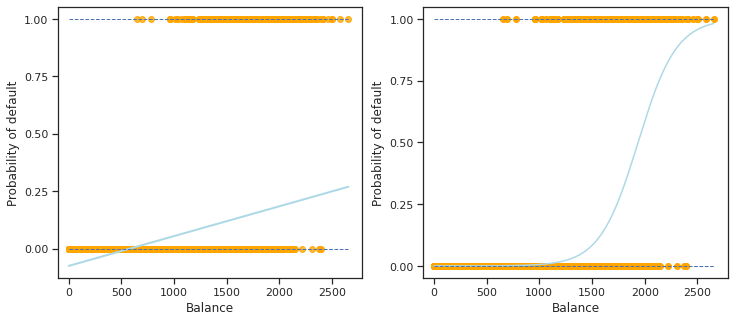

In [5]:
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression()
clf.fit(X_train,y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(df.balance, df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

### Table 4.1

In [6]:
y = df.default.astype("category")

#####  scikit-learn

In [7]:
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
# I do not know the details on the differences between the solvers.
clf = skl_lm.LogisticRegression()
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression()
classes:  ['No' 'Yes']
coefficients:  [[0.00549892]]
intercept : [-10.65132824]


##### statsmodels

In [8]:
X_train = sm.add_constant(df.balance)
est = sm.Logit(y.cat.codes, X_train).fit()
print(est.summary2().tables[1])

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10
             Coef.  Std.Err.          z          P>|z|     [0.025    0.975]
const   -10.651331  0.361169 -29.491287  3.723665e-191 -11.359208 -9.943453
balance   0.005499  0.000220  24.952404  2.010855e-137   0.005067  0.005931


###  Table 4.2

In [9]:
X_train = sm.add_constant(df.student2)

est = sm.Logit(y.cat.codes, X_train).fit()
print(est.summary2().tables[1])

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7
             Coef.  Std.Err.          z     P>|z|    [0.025    0.975]
const    -3.504128  0.070713 -49.554094  0.000000 -3.642723 -3.365532
student2  0.404887  0.115019   3.520177  0.000431  0.179454  0.630320


###  Table 4.3 - Multiple Logistic Regression

In [10]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = sm.Logit(y.cat.codes, X_train).fit()
print(est.summary2().tables[1])

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10
              Coef.  Std.Err.          z          P>|z|     [0.025    0.975]
const    -10.869045  0.492273 -22.079320  4.995499e-108 -11.833882 -9.904209
balance    0.005737  0.000232  24.736506  4.331521e-135   0.005282  0.006191
income     0.000003  0.000008   0.369808   7.115254e-01  -0.000013  0.000019
student2  -0.646776  0.236257  -2.737595   6.189022e-03  -1.109831 -0.183721


### Figure 4.3 - Confounding

In [11]:
# balance and default vectors for students
X_train = df[df.student == 'Yes'].balance.values.reshape(df[df.student == 'Yes'].balance.size,1) 
y = df[df.student == 'Yes'].default2

# balance and default vectors for non-students
X_train2 = df[df.student == 'No'].balance.values.reshape(df[df.student == 'No'].balance.size,1) 
y2 = df[df.student == 'No'].default2

# Vector with balance values for plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression()
clf2 = skl_lm.LogisticRegression()

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

In [12]:
df.groupby(['student','default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


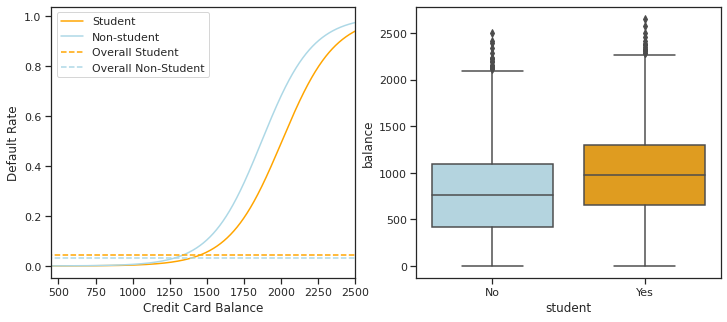

In [13]:
# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, pd.DataFrame(prob)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color='lightblue', label='Non-student')
ax1.hlines(127/2817, colors='orange', label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Right plot
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2,  palette=c_palette);

## 4.4 Linear Discriminant Analysis

### Table 4.4 

In [14]:
X = df[['balance', 'income', 'student2']].values
y = df.default2.values

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


In [15]:
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000



### Table 4.5
Instead of using the probability of 50% as decision boundary, we say that a probability of default of 20% is to be classified as 'Yes'.

In [16]:
decision_prob = 0.2
y_prob = lda.fit(X, y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
False,9435,140
True,232,193


### Figure 4.7 (TODO)

### Figure 4.8 (TODO)

### Table 4.8 (TODO)

### Table 4.9 (TODO)

### Table 4.10 (TODO)

### Figure 4.13 (TODO)

### Figure 4.14 (TODO)

### Table 4.11 (TODO)

### Figure 4.15 (TODO)

#  Lab

### 4.6.3 Linear Discriminant Analysis

In [17]:
df = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/ISLR-python/master/Notebooks/Data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)

In [18]:
X_train = df[:'2004'][['Lag1','Lag2']]
y_train = df[:'2004']['Direction']

X_test = df['2005':][['Lag1','Lag2']]
y_test = df['2005':]['Direction']

lda = LinearDiscriminantAnalysis()
pred = lda.fit(X_train, y_train).predict(X_test)

In [19]:
lda.priors_

array([0.49198397, 0.50801603])

In [20]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [21]:
# These do not seem to correspond to the values from the R output in the book?
lda.coef_

array([[-0.05544078, -0.0443452 ]])

In [22]:
confusion_matrix(y_test, pred).T

array([[ 35,  35],
       [ 76, 106]])

In [23]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

        Down      0.500     0.315     0.387       111
          Up      0.582     0.752     0.656       141

    accuracy                          0.560       252
   macro avg      0.541     0.534     0.522       252
weighted avg      0.546     0.560     0.538       252



In [24]:
pred_p = lda.predict_proba(X_test)

In [25]:
np.unique(pred_p[:,1]>0.5, return_counts=True)

(array([False,  True]), array([ 70, 182]))

In [26]:
np.unique(pred_p[:,1]>0.9, return_counts=True)

(array([False]), array([252]))

### 4.6.4 Quadratic Discriminant Analysis

In [27]:
qda = QuadraticDiscriminantAnalysis()
pred = qda.fit(X_train, y_train).predict(X_test)

In [28]:
qda.priors_

array([0.49198397, 0.50801603])

In [29]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [30]:
confusion_matrix(y_test, pred).T

array([[ 30,  20],
       [ 81, 121]])

In [31]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

        Down      0.600     0.270     0.373       111
          Up      0.599     0.858     0.706       141

    accuracy                          0.599       252
   macro avg      0.600     0.564     0.539       252
weighted avg      0.599     0.599     0.559       252



### 4.6.5 K-Nearest Neighbors

In [32]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[43 58]
 [68 83]]
              precision    recall  f1-score   support

        Down      0.426     0.387     0.406       111
          Up      0.550     0.589     0.568       141

    accuracy                          0.500       252
   macro avg      0.488     0.488     0.487       252
weighted avg      0.495     0.500     0.497       252



In [33]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[48 55]
 [63 86]]
              precision    recall  f1-score   support

        Down      0.466     0.432     0.449       111
          Up      0.577     0.610     0.593       141

    accuracy                          0.532       252
   macro avg      0.522     0.521     0.521       252
weighted avg      0.528     0.532     0.529       252

